# Deep Learning

The basic structure looks like this:

![Basic Nueral Network Structure](https://miro.medium.com/max/1400/1*pR6bSQXgC1Y_lYTeLDqVqg.png)

In [1]:
using Distributions, Random, ReverseDiff, LinearAlgebra, Optim, Plots; pyplot();

In [2]:
xdist = Uniform(0,1)
ydist = Uniform(0,1)
z(x,y) = sin.(x .*2pi) .+ cos.(y .*2pi)
N = 1000
Dxy = [rand(xdist,N) rand(ydist,N)]
D = (1/2).*z(Dxy[:,1],Dxy[:,2]);

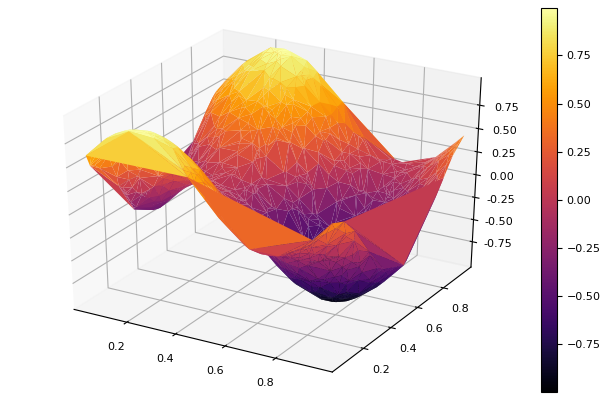

In [3]:
surface(Dxy[:,1],Dxy[:,2],D)

## Make a simple manual Neural network!

- 1 Input layer (two neurons)
- 2 Hidden layers (four neurons each)
- 1 Output layer (1 neuron)

To go from 2 input neurons to 4 hidden layer, we need a 4x2 matrix (with right hand multiplication)!

In [4]:
H1 = randn(4,2)
H1 * Dxy[1,:]

4-element Array{Float64,1}:
  1.3823466800703934
  0.9551731410170743
 -2.046734697713807
  1.3588673679368624

In [5]:
H1 

4×2 Array{Float64,2}:
  1.01617    0.48365
  0.615299   0.437611
 -0.627083  -1.76094
  1.2532     0.17265

To go from H1 to H2, we will need a 4x4 matrix!

In [6]:
H2 = randn(4,4)
H2 * H1 * Dxy[1,:]

4-element Array{Float64,1}:
  1.182741595788643
  1.0193808164375682
 -1.3070018457436627
 -0.5810958861979143

In [7]:
H2

4×4 Array{Float64,2}:
 0.678341   0.0146946  -0.693876   -0.875124
 0.698175   0.194107   -0.0417219  -0.159352
 0.0369992  0.476541    0.678917   -0.31185
 0.359937   0.411908    1.04696     0.493616

To go from H2 to Output, we need a 1x4 matrix.

In [8]:
H3 = randn(1,4)
H3 * H2 * H1 * Dxy[1,:]

1-element Array{Float64,1}:
 -1.2693343248002824

### Not done yet!

We need bias nuerons too!  These give a linear shift to each of the layers.

In [9]:
B1 = randn(4,1)
B2 = randn(4,1)
B3 = randn(1);

In [10]:
(H3 * (H2 * (H1 * Dxy[1,:] + B1) + B2)) + B3

1×1 Array{Float64,2}:
 -2.5959304485589056

### Not done yet!

We need some non-linear activation functions too!  These a slight non-linearity to the model, otherwise it would only be able to learn linear relationships.

In [11]:
# Use the ReLu
r(x) = x > 0 ? x : 0;

In [12]:
r(-2.5)

0

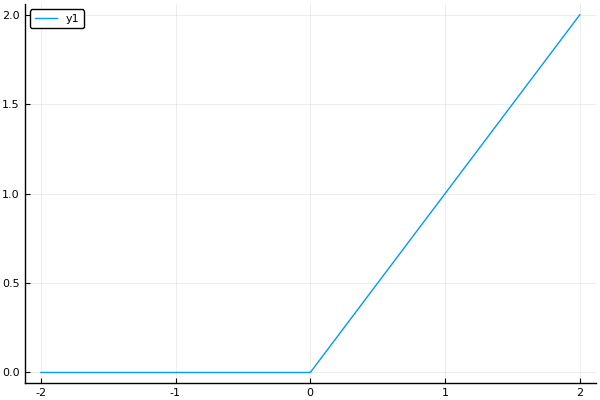

In [13]:
xvals = -2:0.1:2
plot(xvals,r.(xvals))

In [14]:
(H3* (r.(H2 * (r.(H1 * Dxy[1,:] + B1)) + B2))) + B3

1×1 Array{Float64,2}:
 -3.6133640646525182

## Now we can assemble these parts into a single function!

In [15]:
weights = [H1,H2,H3]
bias = [B1,B2,B3]
vars = [weights, bias]
function manual_net(x,v)
    return ((v[1][3]* (r.(v[1][2] * (r.(v[1][1] * x + v[2][1])) + v[2][2]))) + v[2][3])[1]
end;

In [16]:
manual_net(Dxy[1,:],vars)

-3.6133640646525182

In [20]:
function serialize_vars(vars)
    vout = zeros(37)
    vout[1:8] = vars[1][1][:]
    vout[9:24] = vars[1][2][:]
    vout[25:28] = vars[1][3][:]
    vout[29:32] = vars[2][1][:]
    vout[33:36] = vars[2][2][:]
    vout[37] = vars[2][3][1]
    return vout
end;

function deserialize_vars(v)
    h1 = reshape(v[1:8],4,2)
    h2 = reshape(v[9:24],4,4)
    h3 = reshape(v[25:28],1,4)
    b1 = reshape(v[29:32],4,1)
    b2 = reshape(v[33:36],4,1)
    b3 = [v[37]]
    return [[h1, h2, h3], [b1, b2, b3]]
end;

In [21]:
deserialize_vars(serialize_vars(vars));

In [22]:
function manual_net_serialized(x,vfull)
    v = deserialize_vars(vfull)
    return ((v[1][3]* (r.(v[1][2] * (r.(v[1][1] * x + v[2][1])) + v[2][2]))) + v[2][3])[1]
end;

In [23]:
manual_net_serialized(Dxy[1,:],serialize_vars(vars))

-3.6133640646525182

In [24]:
function loss(v; dataxy = Dxy, dataz = D)
    L = 0
    for i = 1:size(dataxy,1)
        L += (dataz[i] - manual_net_serialized(dataxy[i,:],v))^2
    end
    return L
end;

In [25]:
loss(serialize_vars(vars))

7544.741531259913

In [26]:
function eval_all(xy,v)
    estD = zeros(size(xy,1))
    for i = 1:length(estD)
        estD[i] = manual_net(xy[i,:],v)
    end
    return estD
end;

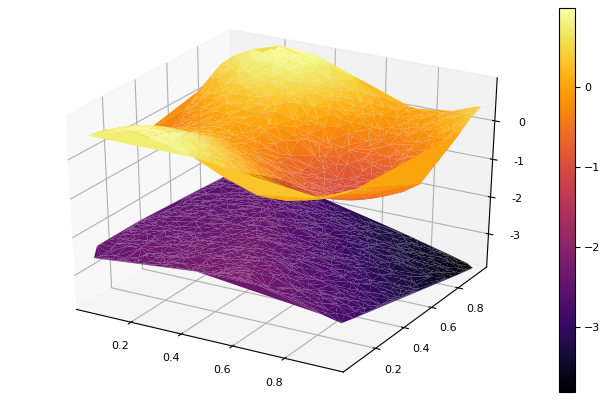

In [27]:
surface(Dxy[:,1],Dxy[:,2],D)
surface!(Dxy[:,1],Dxy[:,2],eval_all(Dxy,vars))

In [28]:
opt1 = optimize(loss,serialize_vars(vars), NelderMead(),
               Optim.Options(g_tol = 1e-8,
                             iterations = 5000))

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [4.72e+00, 1.03e+00, 4.16e-02,  ...]
    Minimum:   4.567869e+01

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [1.02e+00, 6.15e-01, -6.27e-01,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   124  (vs limit Inf)
    Iterations:    5000
    f(x) calls:    6188


In [32]:
opt2 = optimize(loss,serialize_vars(vars), SimulatedAnnealing(),
               Optim.Options(g_tol = 1e-8,
                             iterations = 5000))

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [1.05e+00, 1.97e-01, -5.18e+00,  ...]
    Minimum:   1.647861e+02

 * Found with
    Algorithm:     Simulated Annealing
    Initial Point: [1.02e+00, 6.15e-01, -6.27e-01,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 1.0e-08

 * Work counters
    Seconds run:   99  (vs limit Inf)
    Iterations:    5000
    f(x) calls:    5001


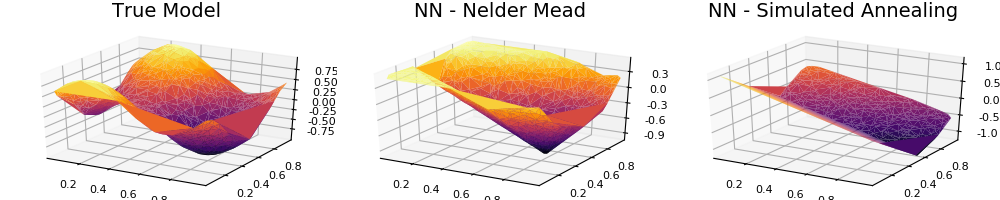

In [38]:
plt = plot(layout=(1,3),size=(1000,200),legend=false)
surface!(plt[1],Dxy[:,1],Dxy[:,2],D,title="True Model")
surface!(plt[2],Dxy[:,1],Dxy[:,2],eval_all(Dxy,deserialize_vars(opt1.minimizer)),title="NN - Nelder Mead")
surface!(plt[3],Dxy[:,1],Dxy[:,2],eval_all(Dxy,deserialize_vars(opt2.minimizer)),title="NN - Simulated Annealing")

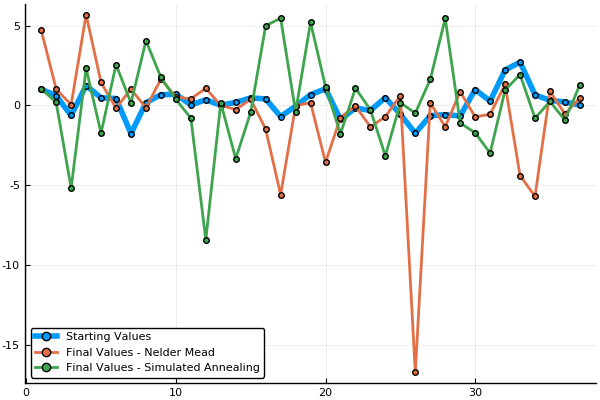

In [39]:
plot(serialize_vars(vars),marker=:circle, linewidth=4, label="Starting Values")
plot!(opt1.minimizer,marker=:circle, linewidth=2, label="Final Values - Nelder Mead")
plot!(opt2.minimizer,marker=:circle, linewidth=2, label="Final Values - Simulated Annealing")

## Getting a Gradient!

In [ ]:
# Not quite working...
# pre-record a GradientTape for `f` using inputs of shape 100x100 with Float64 elements
const f_tape = ReverseDiff.GradientTape(loss, (rand(37)))

# compile `f_tape` into a more optimized representation
const compiled_f_tape = ReverseDiff.compile(f_tape)

# some inputs and work buffers to play around with
a = randn(37)
inputs = a
results = similar(a)
cfg = ReverseDiff.GradientConfig(inputs)

In [ ]:
ReverseDiff.gradient(loss,v)